In [42]:
# !pip install torch_geometric

In [43]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [44]:
dataset = QM9(root='./raw/qm9')
#maximum absolute value of each y in the dataset
y_norm = torch.tensor([2.9556e+01, 1.9662e+02, 1.1663e+01, 5.2654e+00, 1.6928e+01, 3.3748e+03,
        7.4544e+00, 1.9444e+04, 1.9444e+04, 1.9444e+04, 1.9445e+04, 4.6969e+01,
        1.1311e+02, 1.1389e+02, 1.1461e+02, 1.0482e+02, 6.1987e+05, 4.3790e+02,
        2.8295e+02])

## Normalize target values

In [45]:
#description of the dataset
def describe(dataset):
    print(dataset)
    print("y size: ", dataset.y.size())
    # Calculate mean and variance for all features
    mean = torch.mean(dataset.y, dim=0)
    variance = torch.var(dataset.y, dim=0)
    print("Mean of y features:")
    print(mean)
    print("Variance of y features:")
    print(variance)
    print("x size: ", dataset.x.size())

describe(dataset)
dataset._data.y = dataset._data.y/y_norm
print("Normalized y")
describe(dataset)

QM9(130831)
y size:  torch.Size([130831, 19])
Mean of y features:
tensor([ 2.6730e+00,  7.5281e+01, -6.5365e+00,  3.2204e-01,  6.8585e+00,
         1.1894e+03,  4.0569e+00, -1.1179e+04, -1.1179e+04, -1.1179e+04,
        -1.1180e+04,  3.1620e+01, -7.6116e+01, -7.6580e+01, -7.7018e+01,
        -7.0837e+01,  9.9660e+00,  1.4067e+00,  1.1274e+00])
Variance of y features:
tensor([2.2605e+00, 6.6812e+01, 3.5729e-01, 1.6253e+00, 1.6491e+00, 7.8668e+04,
        8.1310e-01, 1.1785e+06, 1.1785e+06, 1.1785e+06, 1.1785e+06, 1.6545e+01,
        1.0658e+02, 1.0848e+02, 1.1002e+02, 9.0219e+01, 3.3506e+06, 2.5627e+00,
        1.2265e+00])
x size:  torch.Size([2359210, 11])
Normalized y
QM9(130831)
y size:  torch.Size([130831, 19])
Mean of y features:
tensor([ 9.0437e-02,  3.8288e-01, -5.6044e-01,  6.1162e-02,  4.0516e-01,
         3.5244e-01,  5.4423e-01, -5.7493e-01, -5.7492e-01, -5.7492e-01,
        -5.7495e-01,  6.7322e-01, -6.7294e-01, -6.7241e-01, -6.7200e-01,
        -6.7579e-01,  1.6078e-05,  3

## Utility functions

In [46]:
def get_adjency_matrix(data):
    #Compute the adjency matrix from the data structure
    A = torch.zeros(data.num_nodes, data.num_nodes, device=device,requires_grad=False)
    for i in range(data.num_edges):
        A[data.edge_index[0][i]][data.edge_index[1][i]] = 1
        A[data.edge_index[1][i]][data.edge_index[0][i]] = 1
    return A

def get_y(data):
    #Return the target value
    return data.y.to(device)

def get_D_minus_1(data):
    #Compute the inverse of the diagnonal matrix of the number of neighbors
    return torch.diag(1/torch.sum(get_adjency_matrix(data), dim=1)).to(device)

def belongs(data):
    #Return the index of the molecule for every node
    return data.batch.to(device)

In [47]:
data = dataset[torch.randint(0, len(dataset),(1,)).item()]
print("Random sample from dataset: ",data)
print(len(data.idx))
adj = get_adjency_matrix(data)
print(adj.shape)



Random sample from dataset:  Data(x=[15, 11], edge_index=[2, 32], edge_attr=[32, 4], y=[1, 19], pos=[15, 3], idx=[1], name='gdb_22713', z=[15])
1
torch.Size([15, 15])


In [48]:
# get distribution of node features
node_features = data.x
print(node_features.shape)

# get distribution of edge features
edge_features = data.edge_attr
print(edge_features.shape)

torch.Size([15, 11])
torch.Size([32, 4])


# GCN Model 

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Message Passing Layer
class MessagePassing(nn.Module):
    def __init__(self, input_dim, output_dim, neighbor_aggr):
        """Message passing layer for graph neural networks.
        Args:
        input_dim: Dimension of input node features
        output_dim: Dimension of output node features
        neighbor_aggr (str: 'mean' or 'sum'): Aggregation function for neighbor information
        """
        super(MessagePassing, self).__init__()
        self.neighbor_aggr = neighbor_aggr
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)

    def forward(self, x, adj):
        """
        x: Node features
        adj: Adjacency matrix
        """
        x_node = self.fc2(x)
        m = self.fc1(torch.mm(adj, x))

        # Message aggregation
        if self.neighbor_aggr == 'sum':
            output = x_node + m
        elif self.neighbor_aggr == 'mean':
            deg = torch.spmm(adj, torch.ones(x.size(0),1, device=x.device))
            output = x_node + torch.div(m, deg)
        else:
            raise ValueError('Unknown neighbor aggregation type, please use "sum" or "mean".')
        
        return output


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, neighbor_aggr, readout, dropout=0):
        """Pure Pytorch implementation of a Graph Convolutional Network.
        Args:
            input_dim: Dimension of input node features
            hidden_dim: Dimension of hidden layers
            output_dim: Dimension of output node features
            neighbor_aggr (str: 'mean' or 'sum'): Aggregation function for neighbor information
            readout (str: 'mean' or 'sum'): Aggregation function for graph embedding
            dropout: Dropout rate
        """
        super(GCN, self).__init__()
        self.readout = readout
        self.mp1 = MessagePassing(input_dim, hidden_dim, neighbor_aggr)
        self.mp2 = MessagePassing(hidden_dim, hidden_dim, neighbor_aggr)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj, idx):
        """
        x:   (N,d) Node features
        adj: (N,N) Adjacency matrix
        idx: (N) Graph Index of nodes
        """
        
        # Message passing layers
        x = self.relu(self.mp1(x, adj))
        x = self.relu(self.mp2(x, adj))
        x = self.dropout(x)
        
        # Readout layer: Aggregation over all nodes to compute graph embedding
        if self.readout == 'sum':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x) 
        elif self.readout == 'mean':
            idx = idx.unsqueeze(1).repeat(1, x.size(1))
            out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            out = out.scatter_add_(0, idx, x)
            count = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device)
            count = count.scatter_add_(0, idx, torch.ones_like(x, device=x.device))
            out = torch.div(out, count)
            
        out = self.fc(out)    
        return out


# Training

## HyperParameters

In [61]:
#get the number of features and the number of output
epochs = 100
lr = 1e-2
loss_fn = nn.L1Loss()
batch_size = 256

## Data Split and Loader

In [62]:
from torch.utils.data import random_split
# Define the sizes of train, test, and validation sets
train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

# Split the dataset into train, test, and validation sets
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create dataloaders for train, test, and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def compute_loss_loader(loader, model, loss):
    with torch.no_grad():
        li_loss = []
        for data in loader:
            data = data.to(device)
            A = get_adjency_matrix(data)
            idx = data.batch
            y_hat = model(data.x, A, idx)
            l = loss(y_hat, data.y)
            li_loss.append(l.item())
    return sum(li_loss)/len(li_loss)

## Model instantiation

In [63]:
data = dataset[0]
n_in = data.num_features
n_out = data.y.shape[1]

GCNmodel = GCN(
    input_dim=n_in,
    hidden_dim=64,
    output_dim=n_out,
    readout="mean",
    neighbor_aggr="mean",
    ).to(device)

li_loss_train = []
li_loss_test = []

optimizer = torch.optim.Adam(GCNmodel.parameters(), lr=lr)

print(GCNmodel)


GCN(
  (mp1): MessagePassing(
    (fc1): Linear(in_features=11, out_features=64, bias=True)
    (fc2): Linear(in_features=11, out_features=64, bias=True)
  )
  (mp2): MessagePassing(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
)


In [64]:
data = train_loader.__iter__().__next__()
print("Random Batch from dataset: ",data)
print(len(data.idx))
adj = get_adjency_matrix(data)
print(adj.shape)

Random Batch from dataset:  DataBatch(x=[4592, 11], edge_index=[2, 9506], edge_attr=[9506, 4], y=[256, 19], pos=[4592, 3], idx=[256], name=[256], z=[4592], batch=[4592], ptr=[257])
256
torch.Size([4592, 4592])


## Tranining loop

In [65]:
from tqdm import tqdm
# Train the model
for epoch in range(epochs):
    loss_current = 0
    for i_b, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        #get Adjency matrix
        X = data.x.to(device)
        A = get_adjency_matrix(data)
        idx = data.batch.to(device)
        y = get_y(data)
        
        y_hat = GCNmodel(X, A, idx)

        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        loss_current += loss.item()
        
    loss_current /= len(train_loader)
    print(f"Epoch {epoch} Loss {loss_current:.4f}")    
    li_loss_train.append(loss_current)
    li_loss_test.append(compute_loss_loader(test_loader, GCNmodel, loss_fn))


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:37<00:00,  2.28it/s]


Epoch 0 Loss 0.0432


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 1 Loss 0.0301


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:36<00:00,  2.29it/s]


Epoch 2 Loss 0.0283


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 3 Loss 0.0264


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:36<00:00,  2.29it/s]


Epoch 4 Loss 0.0251


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:38<00:00,  2.26it/s]


Epoch 5 Loss 0.0246


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:37<00:00,  2.28it/s]


Epoch 6 Loss 0.0243


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:37<00:00,  2.28it/s]


Epoch 7 Loss 0.0235


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:37<00:00,  2.28it/s]


Epoch 8 Loss 0.0234


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:37<00:00,  2.28it/s]


Epoch 9 Loss 0.0234


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:36<00:00,  2.28it/s]


Epoch 10 Loss 0.0231


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 11 Loss 0.0227


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 12 Loss 0.0228


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:36<00:00,  2.29it/s]


Epoch 13 Loss 0.0226


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:34<00:00,  2.31it/s]


Epoch 14 Loss 0.0225


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:34<00:00,  2.31it/s]


Epoch 15 Loss 0.0223


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:34<00:00,  2.31it/s]


Epoch 16 Loss 0.0222


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:34<00:00,  2.31it/s]


Epoch 17 Loss 0.0222


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:34<00:00,  2.31it/s]


Epoch 18 Loss 0.0222


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 19 Loss 0.0222


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:35<00:00,  2.30it/s]


Epoch 20 Loss 0.0220


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 21 Loss 0.0220


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 22 Loss 0.0220


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.38it/s]


Epoch 23 Loss 0.0219


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.38it/s]


Epoch 24 Loss 0.0218


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 25 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 26 Loss 0.0217


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 27 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 28 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 29 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 30 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 31 Loss 0.0215


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 32 Loss 0.0215


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 33 Loss 0.0213


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 34 Loss 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 35 Loss 0.0214


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 36 Loss 0.0213


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 37 Loss 0.0213


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 38 Loss 0.0213


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 39 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.37it/s]


Epoch 40 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.38it/s]


Epoch 41 Loss 0.0212


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.38it/s]


Epoch 42 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 43 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 44 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 45 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 46 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.37it/s]


Epoch 47 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:29<00:00,  2.39it/s]


Epoch 48 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:29<00:00,  2.39it/s]


Epoch 49 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:30<00:00,  2.38it/s]


Epoch 50 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 51 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 52 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 53 Loss 0.0210


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 54 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 55 Loss 0.0211


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.36it/s]


Epoch 56 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 57 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 58 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 59 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 60 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 61 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 62 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.34it/s]


Epoch 63 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 64 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 65 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 66 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 67 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 68 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 69 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 70 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.36it/s]


Epoch 71 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 72 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 73 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 74 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 75 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.34it/s]


Epoch 76 Loss 0.0209


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 77 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 78 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 79 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 80 Loss 0.0207


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:31<00:00,  2.36it/s]


Epoch 81 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.35it/s]


Epoch 82 Loss 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████| 358/358 [02:32<00:00,  2.36it/s]


Epoch 83 Loss 0.0208


KeyboardInterrupt: 

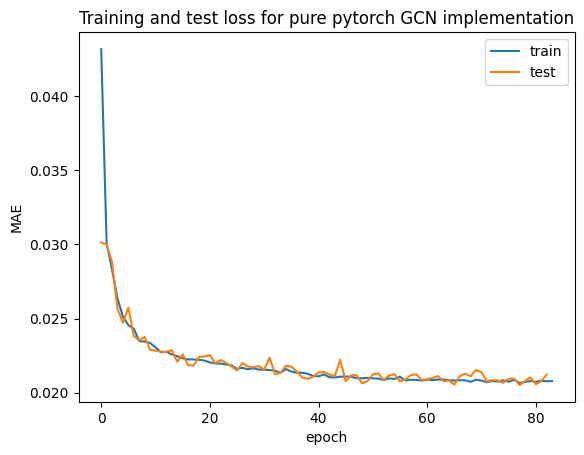

In [68]:
import matplotlib.pyplot as plt
# plot the loss
plt.figure()
plt.title('Training and test loss for pure pytorch GCN implementation')
plt.plot(li_loss_train, label='train')
plt.plot(li_loss_test, label='test')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [67]:
val_loss = compute_loss_loader(val_loader, GCNmodel, loss_fn)
print(f'validation loss {val_loss}')

validation loss 0.02068594040778967
